In [1]:
import glob
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Align import PairwiseAligner
from Bio.SeqUtils import nt_search

In [2]:
def umi_histogram(fastq_path, max_count):
    conscount_values = []
    
    # Regular expression to find CONSCOUNT field and extract the number
    pattern = re.compile(r"CONSCOUNT=(\d+)")

    # Parse the fastq file
    with open(fastq_path, "r") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            match = pattern.search(record.description)
            if match:
                conscount = int(match.group(1))
                # All values greater than max_count are set to max_count
                conscount = min(conscount, max_count)
                conscount_values.append(conscount)
    
    # Plot the histogram
    # bins should be one more than max_count to include the last bin
    plt.hist(conscount_values, bins=max_count+1, range=(0, max_count+1), edgecolor='black')
    
    fastq_basename = fastq_path.split('/')[-1]
    plt.title(f'Distribution of CONSCOUNT for {fastq_basename}')
    plt.xlabel('CONSCOUNT')
    plt.ylabel('Frequency')
    
    ticks = list(range(0, max_count + 1))
    labels = [str(i) for i in range(0, max_count)] + [f"=>{max_count}"]
    plt.xticks(ticks, labels, rotation=90)
    
    plt.show()


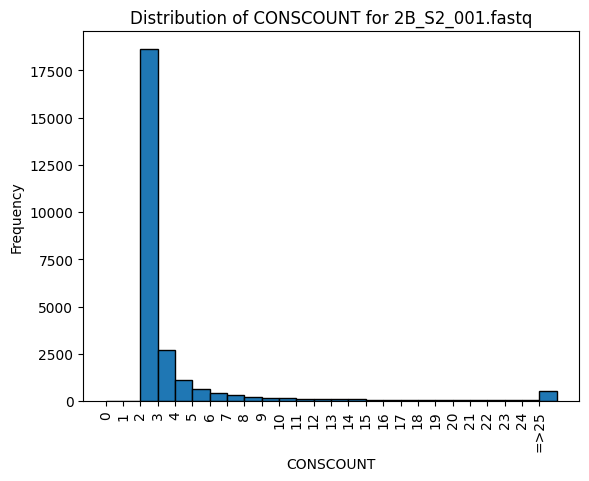

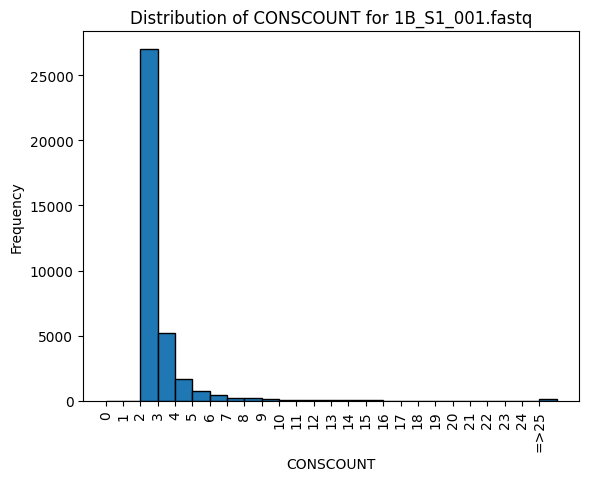

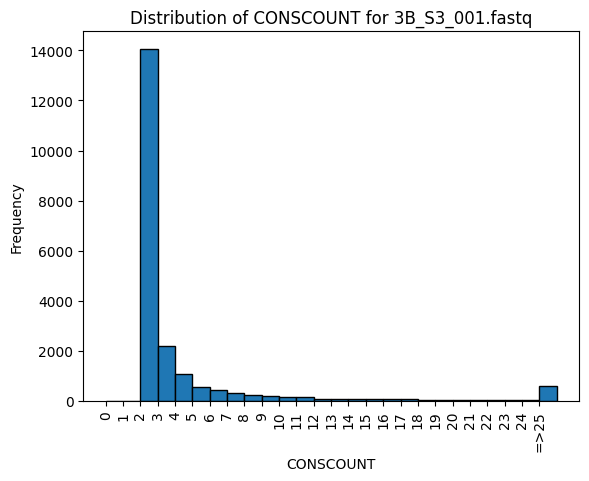

In [3]:
for path in glob.glob("/Users/matsen/re/gcreplay/nextflow/data/passenger/test_run/unique_with_at_least_two_reads/*.fastq"):
    umi_histogram(path, 25)


In [4]:
chigy_lc_stop_with_leader_and_intron = "CATGGAGTCACAGACTCAGGTCTTTGTAGTTGTCTGGTGTTGATGGAGACATTGTGATGACtCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAACgtaagtacacttttctcatctttttttatgtgtaagacacaggttttgca".upper()

chigy_lc_stop_trimmed = "GACATTGTGATGACtCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAAC".upper()

chigy_lc_stop = chigy_lc_stop_with_leader_and_intron

chigy_original = "CATGGAGTCACAGACTCAGGTCTTTGTATACATGTTGCTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACtCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAACgtaagtacacttttctcatctttttttatgtgtaagacacaggttttgca".upper()

deleted_segment = "TACATGTTGCTGTG"

In [5]:
# chigy_lc_stop_with_leader_and_intron subsequence of length 20, then chigy_original, then the deleted segment
# GGTCTTTGTA              GTTGTCTGGT
# GGTCTTTGTATACATGTTGCTGTGGTTGTCTGGT
#           TACATGTTGCTGTG

with open("around-deleted.fasta", "w") as fp:
    fp.write(">around_deleted\n")
    fp.write("GGTCTTTGTAGTTGTCTGGT")

After seeing alignments that look like this:


    Query  1    GGTCTTTGTAGTTGTCTGGT  20
                ||||||||| ||||||||||
    Sbjct  346  GGTCTTTGTGGTTGTCTGGT  327


I corrected `around-deleted-corrected.fasta` to be `GGTCTTTGTGGTTGTCTGGT`.

In [6]:
# Get a list of all the files that match the pattern "passenger-blast/*.blast.tsv"
blast_files = glob.glob("passenger-blast/*.blast.tsv")

# Create an empty list to hold the dataframes
dfs = []

# Loop over the files and read each one into a dataframe
for blast_file in blast_files:
    blast_df = pd.read_csv(blast_file, sep="\t", header=None, names=["query", "subject", "identity", "length", "mismatches", "gap_openings", "q_start", "q_end", "s_start", "s_end", "evalue", "bitscore"])
    # Add a "dataset" column to the dataframe
    blast_df["dataset"] = os.path.basename(blast_file).split('.')[0]

    fasta_file = blast_file.replace(".blast.tsv", ".fasta")
    seq_dict = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    # Note that the sequences in the FASTA file are on the reverse strand, so we're doing reverse complement here.
    matching_seqs = {name: str(seq_dict[name].seq.reverse_complement()) for name in blast_results['subject'] if name in seq_dict}
    seq_df = pd.DataFrame(list(matching_seqs.items()), columns=['subject', 'sequence'])
    merged_df = pd.merge(blast_df, seq_df, on='subject', how='inner')
    dfs.append(merged_df)

# Concatenate the dataframes together
blast_results = pd.concat(dfs, ignore_index=True)

blast_results = blast_results[blast_results["length"] == 20]

assert len(blast_results) == len(set(blast_results["subject"]))

# assert that s_start is greater than s_end for every row, meaning that the subject is on the reverse strand
assert np.all(blast_results["s_start"] > blast_results["s_end"])

blast_results

,query,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,bitscore,dataset
6934,around_deleted_corrected,TTAGTTCCGGCATCATT|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001
6935,around_deleted_corrected,TCCGGTCGCATACGGTT|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001
6936,around_deleted_corrected,AAAGGACATCAAATTGA|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001
6937,around_deleted_corrected,GAGGAAGGGAGAGAGAG|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,257,238,0.000057,40.1,2B_S2_001
6938,around_deleted_corrected,GGAGAAGTTTAATCAGG|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,257,238,0.000057,40.1,2B_S2_001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18401,around_deleted_corrected,AGTCAAGCTGTACCAAT|PRCONS=TS-shift4|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.011000,32.2,3B_S3_001
18402,around_deleted_corrected,CAGGATGGGACAGAGAG|PRCONS=TS-shift1|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.011000,32.2,3B_S3_001
18403,around_deleted_corrected,AAATGATGTACAATGTT|PRCONS=TS-shift2|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.011000,32.2,3B_S3_001
18405,around_deleted_corrected,TTAACTCGACTAATGCA|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.011000,32.2,3B_S3_001


In [7]:
# Read and filter FASTA sequences
fasta_file = "passenger-blast/2B_S2_001.fasta"
seq_dict = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))

# Note that the sequences in the FASTA file are on the reverse strand, so we're doing reverse complement here.
matching_seqs = {name: str(seq_dict[name].seq.reverse_complement()) for name in blast_results['subject'] if name in seq_dict}
seq_df = pd.DataFrame(list(matching_seqs.items()), columns=['subject', 'sequence'])
blast_df = pd.merge(blast_results, seq_df, on='subject', how='inner')

blast_df


,query,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,bitscore,dataset,sequence
0,around_deleted_corrected,TTAGTTCCGGCATCATT|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...
1,around_deleted_corrected,TCCGGTCGCATACGGTT|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GACGCGCGCCTCCACCATGGNGTCACAGACTCAGGTCTTTGTGGTT...
2,around_deleted_corrected,AAAGGACATCAAATTGA|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTG...
3,around_deleted_corrected,GAGGAAGGGAGAGAGAG|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,257,238,0.000057,40.1,2B_S2_001,GAGAGACGCGCGCCTCCACCATGGNGTCACAGACTCAGGTCTTTGT...
4,around_deleted_corrected,GGAGAAGTTTAATCAGG|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,257,238,0.000057,40.1,2B_S2_001,GGAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2959,around_deleted_corrected,GTTCATAGAGTTCTTGA|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.014000,32.2,2B_S2_001,AGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTCTGTG...
2960,around_deleted_corrected,CAATTTTAAAATGCGTT|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.014000,32.2,2B_S2_001,GGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCAT...
2961,around_deleted_corrected,GTTGGAACTACTAAGCG|PRCONS=TS-shift2|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.014000,32.2,2B_S2_001,AGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGAG...
2962,around_deleted_corrected,GCTCGTTCTACAGACAA|PRCONS=TS-shift2|SEQORIENT=F...,95.0,20,1,0,1,20,231,212,0.014000,32.2,2B_S2_001,GGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGT...


In [8]:
# Create an aligner object
aligner = PairwiseAligner()

# Set the match score to 1
aligner.match_score = 1
# Set the mismatch score to -1
aligner.mismatch_score = -1

# Set the gap open penalty
aligner.open_gap_score = -5
# Set the gap extend penalty
aligner.extend_gap_score = -2


def oneline_print_alignment(alignment):
    aligned_seq1_str = str(alignment[0])
    aligned_seq2_str = str(alignment[1])

    # Print sequence 1
    print(aligned_seq1_str)
    
    match_str = ''.join('|' if a == b and a != '-' else '.' if a != '-' and b != '-' else ' ' for a, b in zip(aligned_seq1_str, aligned_seq2_str))

    print(match_str)
    
    # Print sequence 2
    print(aligned_seq2_str)


def pretty_print_alignments(alignment_df):
    for index, row in alignment_df.iterrows():
        sequence = row["sequence"]
        alignments = aligner.align(chigy_lc_stop_trimmed, sequence)
        
        print(f"> {row['dataset']} {row['Sequence number']}")
        
        # Get the first alignment (if it exists) and print
        if alignments:
            alignment = alignments[0]
            oneline_print_alignment(alignment)
        else:
            print("No alignment found.\n")
        print()


In [9]:
def summarize_alignment(alignment):
    """
    This function takes in an alignment object where the first sequence is the
    template, and returns a list with
    the sequence of gap lengths in the template and the positions of mutations,
    indexed by non-gap sites in the template sequence.
    We do not consider read gaps as mutations because most of the time they are
    just from sequence length variation.
    
    :param alignment: Biopython alignment object
    :return: Tuple (list of gap lengths in the template, list of mutation positions)
    """
    gap_lengths = []
    mutation_positions = []

    # Extracting aligned sequences from alignment object
    template_seq = str(alignment[0])
    read_seq = str(alignment[1])

    gap_count = 0
    non_gap_index = 0  # This is used to index positions by non-gap sites in the template sequence

    for template_base, read_base in zip(template_seq, read_seq):
        if template_base == '-':
            gap_count += 1
        else:
            if gap_count > 0:
                gap_lengths.append(gap_count)
                gap_count = 0  # Reset the gap count after a gap sequence has ended

            if template_base != read_base and read_base != '-' and read_base != 'N':
                mutation_positions.append(non_gap_index)
            
            non_gap_index += 1  # Increment the non-gap index whenever a non-gap character is encountered in the template
    
    # In case the sequence ends with gaps
    if gap_count > 0:
        gap_lengths.append(gap_count)
    
    return gap_lengths, mutation_positions


def test_summarize_alignment():
    """
    original alignment:
    --AAA---AA
    A-C-AAAACA

    after deleting columns with gaps in template:
    AAAAA
    C-ACA

    So we have mutations at positions 0, 3 (site 1 is a gap)
    """
    alignment = ['--AAA---AA', 'A-C-AAAACA']
    
    # Call the function with this manual alignment
    gap_lengths, mutation_positions = summarize_alignment(alignment)

    # Expected outputs
    expected_gap_lengths = [2, 3]
    expected_mutation_positions = [0, 3]
    
    assert gap_lengths == expected_gap_lengths, f"Expected {expected_gap_lengths}, but got {gap_lengths}"
    assert mutation_positions == expected_mutation_positions, f"Expected {expected_mutation_positions}, but got {mutation_positions}"
    
test_summarize_alignment()


In [10]:
def run_alignment(template, sequence):
    alignments = aligner.align(template, sequence)
    assert alignments is not None, "No alignment found."
    return alignments[0]

def perform_alignment_and_summary(row):
    """Note that the mutation_positions are with repsect to the trimmed template
    sequence, whereas the gap_lengths are with respect to the original template
    sequence."""
    sequence = row["sequence"]
    alignment = run_alignment(chigy_lc_stop_with_leader_and_intron, sequence)
    gap_lengths, _ = summarize_alignment(alignment)
    alignment = run_alignment(chigy_lc_stop_trimmed, sequence)
    _, mutation_positions = summarize_alignment(alignment)
    
    return pd.Series({
        'gap_segment_count': len(gap_lengths),
        'mutation_positions': mutation_positions,
    })

alignment_summary_df = blast_df.apply(perform_alignment_and_summary, axis=1)

# Concatenating the new DataFrame with the original one horizontally
processed_stop_df = pd.concat([blast_df, alignment_summary_df], axis=1)

processed_stop_df["mutation_count"] = processed_stop_df["mutation_positions"].apply(len)

In [11]:
processed_stop_df["Sequence number"] = processed_stop_df.index

processed_stop_df

,query,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,bitscore,dataset,sequence,gap_segment_count,mutation_positions,mutation_count,Sequence number
0,around_deleted_corrected,TTAGTTCCGGCATCATT|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,1,[298],1,0
1,around_deleted_corrected,TCCGGTCGCATACGGTT|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GACGCGCGCCTCCACCATGGNGTCACAGACTCAGGTCTTTGTGGTT...,1,[],0,1
2,around_deleted_corrected,AAAGGACATCAAATTGA|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTG...,1,"[98, 233, 277]",3,2
3,around_deleted_corrected,GAGGAAGGGAGAGAGAG|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,257,238,0.000057,40.1,2B_S2_001,GAGAGACGCGCGCCTCCACCATGGNGTCACAGACTCAGGTCTTTGT...,1,"[2, 14, 28, 30, 31, 32, 42, 43, 44, 47, 48, 53...",74,3
4,around_deleted_corrected,GGAGAAGTTTAATCAGG|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,257,238,0.000057,40.1,2B_S2_001,GGAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTG...,1,"[7, 14, 28, 30, 31, 32, 42, 43, 44, 45, 47, 48...",75,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2959,around_deleted_corrected,GTTCATAGAGTTCTTGA|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.014000,32.2,2B_S2_001,AGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTCTGTG...,1,[30],1,2959
2960,around_deleted_corrected,CAATTTTAAAATGCGTT|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.014000,32.2,2B_S2_001,GGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCAT...,1,[],0,2960
2961,around_deleted_corrected,GTTGGAACTACTAAGCG|PRCONS=TS-shift2|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.014000,32.2,2B_S2_001,AGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGAG...,1,[],0,2961
2962,around_deleted_corrected,GCTCGTTCTACAGACAA|PRCONS=TS-shift2|SEQORIENT=F...,95.0,20,1,0,1,20,231,212,0.014000,32.2,2B_S2_001,GGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGT...,0,"[14, 61, 63, 66, 67, 70, 73, 74, 75, 76, 77, 8...",22,2962


In [12]:
pretty_print_alignments(processed_stop_df.head())

> 2B_S2_001 0
-------------------------------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC
                                                                                     ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||.||||||||.||||||||||||||||||||||||.||..|||.|||||||||||||||||||||||||||||||||.||||||.||||||||||||||.|||||||.|||.|.|||||||||..||||||||||||||||||||||||.|||||||||.|||||||||||.|||.||.|||||||||.|||||||.||||||||||||.|||||     
GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATG

In [13]:
# Group by 'dataset' and count the number of rows in each group
row_counts_by_dataset = processed_stop_df.groupby('dataset').size()

# Print the count of rows for each 'dataset'
print(row_counts_by_dataset)


dataset
2B_S2_001    2964
dtype: int64


In [14]:
print(processed_stop_df["mutation_count"].value_counts()[:20].sort_index())


mutation_count
0     1706
1      559
2      143
3       70
4       16
5       12
49       9
63       8
64      11
77       9
78       9
83      11
84      15
85      18
86      37
87      39
88      49
89      53
90      31
91      10
Name: count, dtype: int64


In [15]:
# restrict chigy_stop_no_gap_df to exclude rows with more than 40 mutations and exclude dataset 1B.
chigy_believable = processed_stop_df[(processed_stop_df["mutation_count"] <= 40) & (processed_stop_df["dataset"] != "1B_S1_001")].copy()

chigy_believable

,query,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,bitscore,dataset,sequence,gap_segment_count,mutation_positions,mutation_count,Sequence number
0,around_deleted_corrected,TTAGTTCCGGCATCATT|CONSCOUNT=2|PRCONS=TS-shift4...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,1,[298],1,0
1,around_deleted_corrected,TCCGGTCGCATACGGTT|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GACGCGCGCCTCCACCATGGNGTCACAGACTCAGGTCTTTGTGGTT...,1,[],0,1
2,around_deleted_corrected,AAAGGACATCAAATTGA|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTG...,1,"[98, 233, 277]",3,2
6,around_deleted_corrected,GGACAAACACAACAAAC|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,GAAGCATCCTCTCTNCCAGCTCTCAGAGACGCGCGCCTCCACCATG...,1,[],0,6
7,around_deleted_corrected,TGGGGTAAGGATTTCCA|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,346,327,0.000057,40.1,2B_S2_001,AGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAGA...,1,[],0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2959,around_deleted_corrected,GTTCATAGAGTTCTTGA|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.014000,32.2,2B_S2_001,AGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTCTGTG...,1,[30],1,2959
2960,around_deleted_corrected,CAATTTTAAAATGCGTT|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.014000,32.2,2B_S2_001,GGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCAT...,1,[],0,2960
2961,around_deleted_corrected,GTTGGAACTACTAAGCG|PRCONS=TS-shift2|SEQORIENT=F...,95.0,20,1,0,1,20,346,327,0.014000,32.2,2B_S2_001,AGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGAG...,1,[],0,2961
2962,around_deleted_corrected,GCTCGTTCTACAGACAA|PRCONS=TS-shift2|SEQORIENT=F...,95.0,20,1,0,1,20,231,212,0.014000,32.2,2B_S2_001,GGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGT...,0,"[14, 61, 63, 66, 67, 70, 73, 74, 75, 76, 77, 8...",22,2962


In [16]:
chigy_believable["gap_segment_count"].value_counts()

gap_segment_count
1    2451
2      38
0      34
3       1
5       1
8       1
Name: count, dtype: int64

/Users/matsen/mambaforge/envs/gcreplay/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


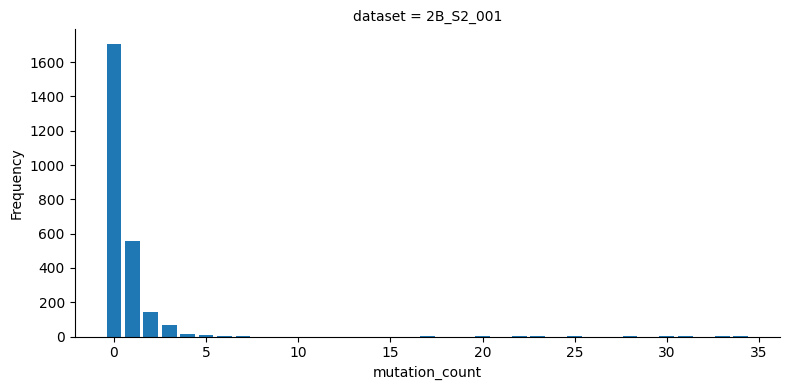

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of unique datasets
num_datasets = chigy_believable['dataset'].nunique()

# Find the maximum mutation count to set the bin edges
max_mutation_count = chigy_believable['mutation_count'].max()
bin_edges = range(0, max_mutation_count + 2)  # +1 for inclusive last bin, +1 for the rightmost edge

# Set up the FacetGrid
g = sns.FacetGrid(chigy_believable, row="dataset", height=4, aspect=2, sharex=True, sharey=False)

# Map a histogram to each subplot
g.map(plt.hist, "mutation_count", bins=bin_edges, align='left', rwidth=0.8)

# Adjust the subplot parameters for better layout
g.fig.subplots_adjust(hspace=0.4)  # adjust the space between plots

# Set y-axis label and make the layout tight
g.set_axis_labels(y_var="Frequency")
plt.tight_layout()

# Show the plots
plt.show()


In [18]:
pretty_print_alignments(chigy_believable[chigy_believable["mutation_count"] == 1].head())

> 2B_S2_001 0
-------------------------------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC
                                                                                     ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||.||||||||.||||||||||||||||||||||||.||..|||.|||||||||||||||||||||||||||||||||.||||||.||||||||||||||.|||||||.|||.|.|||||||||..||||||||||||||||||||||||.|||||||||.|||||||||||.|||.||.|||||||||.|||||||.||||||||||||.|||||     
GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATG

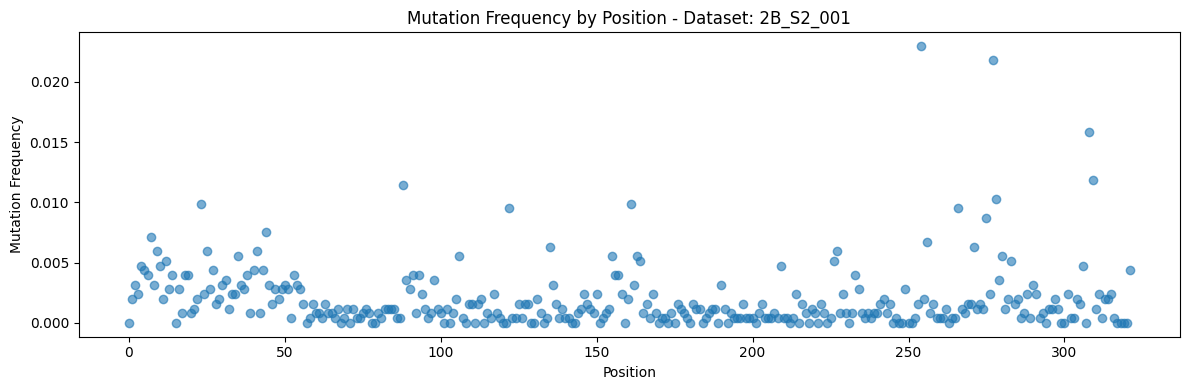

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Get the unique datasets
unique_datasets = chigy_believable['dataset'].unique()

# Set up the figure and the array of subplots
fig, axs = plt.subplots(len(unique_datasets), 1, figsize=(12, 4*len(unique_datasets)))

# Iterate over unique datasets and create a subplot for each one
for index, dataset in enumerate(unique_datasets):
    # Get the ax for this subplot
    ax = axs[index] if len(unique_datasets) > 1 else axs
    
    # Filter DataFrame for this dataset 
    filtered_df = chigy_believable[chigy_believable['dataset'] == dataset]
    
    # Find the maximum value in the mutation_positions column to know the size of the array
    max_position = filtered_df['mutation_positions'].apply(lambda x: max(x) if x else 0).max()
    
    # Initialize the numpy array with zeroes
    mutation_counts_by_position = np.zeros(max_position + 1, dtype=int)
    
    # Iterate through the mutation_positions column and increment the corresponding position in the array
    for positions in filtered_df['mutation_positions']:
        if positions:  # Check if the list is not empty
            for position in positions:
                mutation_counts_by_position[position] += 1
    
    # Calculating Mutation Frequency by dividing by the total read count in the current dataset
    total_read_count = len(filtered_df)
    mutation_frequency_by_position = mutation_counts_by_position / total_read_count
    
    # Plotting
    ax.scatter(range(len(mutation_frequency_by_position)), mutation_frequency_by_position, alpha=0.6)
    ax.set_title(f'Mutation Frequency by Position - Dataset: {dataset}')
    ax.set_xlabel('Position')
    ax.set_ylabel('Mutation Frequency')

plt.tight_layout()
plt.show()


In [20]:
pretty_print_alignments(chigy_believable.sample(500))

> 2B_S2_001 1065
----------------------------------------------------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC
                                                                                                          |||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||     
AGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCNAGCTCTCAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGT

In [21]:
# Define the name of the fasta file
filename = 'sequences.fasta'

# Open the file in write mode to write the chigy_lc_stop_trimmed sequence
with open(filename, 'w') as file:
    file.write('>chigy_lc_stop_trimmed\n')
    file.write(chigy_lc_stop_trimmed + '\n')

# Now, open the file in append mode to add sequences from the dataframe
with open(filename, 'a') as file:
    for index, row in chigy_believable.iterrows():
        header = '>' + row['dataset'] + str(row['Sequence number']) + '\n'
        sequence = row['sequence'] + '\n'
        file.write(header)
        file.write(sequence)
